# Build Metric

In this notebook, tackle opportunity, missed tackle opportunity, and tackle conversions are tabulated for every defensive player with solo tackles > 30. Subsequently, the tackle opportunity rate, missed tackle opportunity rate, and tackle conversion rate are derived using the total active plays that each player is involved in. The data is then visualized in a variety of manners to highlight patterns and assess individual player performance. 

Steps: 
1) Load model trained from train_model.ipynb
2) Load tracking data preprocessed from load_data.ipynb
3) Run inference on every play in the tracking data, and tabulate tackle opportunities, missed tackle opportunities, and tackle conversions 
4) Convert these metrics into rates
5) Visualize data in a variety of tables and plots 

In [1]:
import numpy as np
import pandas as pd
import pickle 
import os 
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import datetime

from data_preprocessing import build_inference_tackle_sequences

root_dir = os.getcwd()

**Note: Replace filenames with your specific XGBoost model, test_tracking_data, train_tracking_data, and tackle_sequences filenames.**

In [2]:
# Load pre-trained XGBoost Model 
print("Loading Model...")
clf = xgb.XGBClassifier()
clf.load_model(os.path.join(root_dir, "save/XGBoost_01082024-1705.model"))

# Load tracking data 
print("Loading Tracking Data...")
df_tracking_test = pickle.load(open(os.path.join(root_dir, "save/test_tracking_data_01072024-2324.pkl"), "rb"))
df_tracking_train = pickle.load(open(os.path.join(root_dir, "save/train_tracking_data_01072024-2324.pkl"), "rb"))
ts_lists = pickle.load(open(os.path.join(root_dir, "save/tackle_sequences_01072024-2324.pkl"), "rb"))
tackle_sequences_train = ts_lists["train"]
tackle_sequences_test = ts_lists["test"]

Loading Model...
Loading Tracking Data...


## Tabulate Metrics

Calculate tackle opportunities, missed opportunities, and conversion rate.
Tackle opportunity as any instance where the tackle probability increases above 75% > 0.5 seconds consecutively
Missed tackle opportunity as any instance where the tackle probability increases above 75% > 0.5 seconds consecutively, and subsequently decreases below 75% for > 0.5 seconds consecutively

**NOTE: Tabulating metrics on all plays takes a little over 5 hours to run on an M1 Macbook Pro**

In [3]:
# Step 1) Identify defensive players with > X tackles
ts_list_total = tackle_sequences_test + tackle_sequences_train
df_players = pd.read_csv(os.path.join(root_dir, "data/players.csv"))
df_tackles = pd.read_csv(os.path.join(root_dir, "data/tackles.csv"))
df_tracking = pd.concat([df_tracking_train, df_tracking_test])
tks_by_player = df_tackles.groupby("nflId").sum()
tks_by_player = tks_by_player.drop(columns=["gameId", "playId"])            # these cols no longer have meaning after sum()
made_tks_30 = tks_by_player[tks_by_player["tackle"] > 30]                   # only look at players with > 30 solo tackles over weeks 1-9
ids = made_tks_30.index.tolist()

# Step 2) For each of those defensive players, iterate through all plays and identify the ones that they are involved in
df_converted_tackles = pd.DataFrame(columns=["nflId", "display_name", "active_plays", "position", "made_tackles", "tackle_opportunities", "tackle_opportunity_rate", "missed_opportunity_rate", "tackle_conversion_ratio"])
ct = 0          # counter for how many players have been processed
for id in ids: 
    ct += 1                 # increment count
    skipped_ct = 0          # counter for skipped plays
    tackle_opp_ct = 0       # tackle opportunity counter
    missed_opp_ct = 0       # missed tackle opportunity counter
    tackle_made_ct = 0      # made tackle counter
    
    df_with_player = df_tracking[(df_tracking.nflId == id)]
    gb = df_with_player.groupby(["gameId", "playId"])
    
    # Below, iterate through each (gameId, playId) combo that the defender is involved in. Extract the tracking data for both the defender and the ballcarrier of the play. Run inference. 
    for (gameId, playId), _ in gb: 
        # Isolate tracking data for this play
        df_tracking_play = df_tracking[(df_tracking.gameId == gameId) & (df_tracking.playId == playId)]
        assert not df_tracking_play.empty, f"ERROR: Play ({gameId}, {playId})  not found."

        ts_list = build_inference_tackle_sequences(df_tracking_play, gameId, playId, id, offset_frames=10, sequence_len=1, dt=1, verbose=False)
        if len(ts_list) == 0: 
            skipped_ct += 1
            continue
        
        # Step 3) Run inference, and track state to assign tackle opportunities and missed opportunities 
        state = 0       # state tracker to count tackle opps and missed tackles 
                        # state = 0, no opportunity
                        # state = 11-14, tackle opp counter for 1-4 frames. Tackle opp assigned if prob is > 75% when state == 14
                        # state = 15, tackle opp steady state
                        # state = 21 - 24, missed tackle opp counter for 1-4 frames. Missed tackle opp assigned if prob is < 75% when state == 24

        for ts in ts_list:
            x = ts.input_tensor
            x = x.view(x.shape[0], -1).cpu().numpy()
            probs = clf.predict_proba(x)
            
            if probs[0, 1] > 0.75:
                if state == 0: 
                    state = 11
                elif state in [11, 12, 13]:  # increment tackle opp counter
                    state += 1
                elif state == 14:                # assign tackle opp
                    state += 1                   # enter tackle opp steady state
                    tackle_opp_ct += 1         
                elif state in [21, 22, 23, 24]:  # return back to tackle opp steady state, disable missed tackle opp counter
                    state = 15
            else:
                if state in [0, 11, 12, 13, 14]:  # reset tackle opp counter
                    state = 0
                elif state == 15:                 # start missed tackle opp counter
                    state = 21
                elif state in [21, 22, 23]:       # increment missed tackle opp counter
                    state += 1
                elif state == 24:                 # assign missed tackle opp, return to state 0
                    state = 0
                    missed_opp_ct += 1
                
        # Step 4) Cross-reference tackles.csv to see if the player successfully made a tackle or not 
        tks_myPlayer = df_tackles[(df_tackles.gameId == gameId) & (df_tackles.playId == playId) & (df_tackles.nflId == id)]
        if tks_myPlayer.empty:
            pass
        elif ((tks_myPlayer.tackle == 1) | (tks_myPlayer.assist == 1)).item():
            tackle_made_ct += 1

    # Step 5) Tabulate all statistics and rates
    player_stats = {"nflId": [id], 
                    "display_name": [df_players[df_players.nflId == id].displayName.values[0]],
                    "active_plays": [len(gb)],
                    "position": [df_players[df_players.nflId == id].position.values[0]],
                    "made_tackles": [tackle_made_ct],
                    "tackle_opportunities": [tackle_opp_ct],
                    "missed_opportunities": [missed_opp_ct],
                    "tackle_opportunity_rate": [tackle_opp_ct / len(gb)],
                    "missed_opportunity_rate": [missed_opp_ct / tackle_opp_ct],
                    "tackle_conversion_rate": [tackle_made_ct / tackle_opp_ct]
                    }
    df_player_stats = pd.DataFrame(player_stats, index=player_stats["nflId"])
    df_converted_tackles = pd.concat([df_converted_tackles, df_player_stats])
    print(f"[{ct}/{len(ids)}] Completed analysis for player {id}, skipped_ct = {skipped_ct}, active_plays_ct = {len(gb)}, tackle_made_ct = {tackle_made_ct}, tackle_opp_ct = {tackle_opp_ct}, missed_opp_ct = {missed_opp_ct}, tackle_conversion_rate = {(tackle_made_ct / tackle_opp_ct):.2f}")
    
# Save computed tackle opportunity data
current_datetime = datetime.now().strftime("%m%d%Y-%H%M")
pickle.dump(df_converted_tackles, open(os.path.join(root_dir, f"save/tackle_opportunity_data_{current_datetime}.pkl"), "wb"))

/var/folders/c7/4djdm2814z51mg9ff4pvhx_r0000gn/T/ipykernel_3964/839673826.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_converted_tackles = pd.concat([df_converted_tackles, df_player_stats])


[1/83] Completed analysis for player 35466, skipped_ct = 0, active_plays_ct = 361, tackle_made_ct = 45, tackle_opp_ct = 64, missed_opp_ct = 9, tackle_conversion_rate = 0.70
[2/83] Completed analysis for player 38559, skipped_ct = 0, active_plays_ct = 296, tackle_made_ct = 41, tackle_opp_ct = 71, missed_opp_ct = 6, tackle_conversion_rate = 0.58
[3/83] Completed analysis for player 38577, skipped_ct = 0, active_plays_ct = 336, tackle_made_ct = 60, tackle_opp_ct = 131, missed_opp_ct = 34, tackle_conversion_rate = 0.46
[4/83] Completed analysis for player 38588, skipped_ct = 0, active_plays_ct = 391, tackle_made_ct = 55, tackle_opp_ct = 130, missed_opp_ct = 38, tackle_conversion_rate = 0.42
[5/83] Completed analysis for player 41243, skipped_ct = 0, active_plays_ct = 393, tackle_made_ct = 82, tackle_opp_ct = 181, missed_opp_ct = 44, tackle_conversion_rate = 0.45
[6/83] Completed analysis for player 41300, skipped_ct = 0, active_plays_ct = 337, tackle_made_ct = 51, tackle_opp_ct = 124, miss

## Data Visualization

In [5]:
# Output tackle opp, missed tackle opp, and rate data in HTML table format for the secondary 

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Make HTML Tables
def value_to_cell_color(value, ranges):
    norm_value = (value - ranges[0]) / (ranges[1] - ranges[0])
    
    # Create a ScalarMappable to map the normalized value to a color in "coolwarm"
    cmap = plt.get_cmap('summer_r')
    norm = mcolors.Normalize(vmin=0, vmax=1)
    scalar_mappable = cm.ScalarMappable(cmap=cmap, norm=norm)

    # Get the RGBA color based on the normalized value
    rgba_color = scalar_mappable.to_rgba(norm_value)

    # Convert the RGBA color to hex
    hex_color = mcolors.to_hex(rgba_color)

    return hex_color

def value_to_text_color(value, ranges): 
    norm_value = (value - ranges[0]) / (ranges[1] - ranges[0])
    if norm_value < 0.5: 
        return "black"
    else: 
        return "white"

def make_pretty(styler):
    styler.set_caption("Player Tackling Efficiency Metrics").set_table_styles([{'selector': 'caption', 'props': 'caption-side: bottom; font-size:1.25em;'}], overwrite=False)
    show_cols = ["active_plays", "tackles_per_play", "tackle_opportunity_rate", "tackle_conversion_rate", "missed_opportunity_rate"]
    styler.hide([col for col in styler.columns if col not in show_cols], axis=1)
    styler.format(precision=2)
    styler.relabel_index(["Active Plays", "Tackles per Play", "Tackle Opportunity Rate", "Tackle Conversion Rate", "Missed Opportunity Rate"], axis=1)
    
    return styler

def color_rates(styler, df): 
    v_or = [df["tackle_opportunity_rate"].values.min(), df["tackle_opportunity_rate"].values.max()]
    v_tackle = [df["tackles_per_play"].values.min(), df["tackles_per_play"].values.max()]
    styler.map(lambda v: f'background: {value_to_cell_color(v, v_or)}; color: {value_to_text_color(v, v_or)}', subset=["tackle_opportunity_rate"])
    styler.map(lambda v: f'background: {value_to_cell_color(v, v_tackle)}; color: {value_to_text_color(v, v_tackle)}', subset=["tackles_per_play"])

    return styler

def print_html(styled_df):
    
    # html with style block 
    html_with_style_block = styled_df.to_html(exclude_styles=False, doctype_html=False)

    # remove style block
    style_block_start = html_with_style_block.find('<style')
    style_block_end = html_with_style_block.find('</style>') + len('</style>')
    style_block = html_with_style_block[style_block_start:style_block_end]

    # Remove the style block from the original HTML
    html_without_style_block = html_with_style_block[:style_block_start] + html_with_style_block[style_block_end:]

    # iterate through the style block and add the style inline to the HTML element
    state = 0
    styles_dict = {}
    selectors = []
    html_with_inline_styles = html_without_style_block
    for line in style_block.split('\n'):
        if line == '<style type="text/css">':
            continue
        if line == '</style>':
            break
        if state == 0:
            if '{' in line:   # find selectors
                state += 1
                selectors = [l.strip().strip("#") for l in line[:line.index('{')].split(",")]
                styles_dict = {}
                continue
            else: 
                break        # end of style block
        elif state == 1:     # find styles and store in styles_dict
            if '}' in line:
                for selector in selectors:
                    style_str = ""
                    for k, v in styles_dict.items():
                        style_str += f" {k}: {v}"
                    html_with_inline_styles = html_with_inline_styles.replace(selector, f'"{selector}" style="{style_str}')
                state = 0
            else:
                styles = line.strip().split(':')
                styles_dict[styles[0].strip()] = styles[1].strip()
                continue

    print(html_with_inline_styles)
    
df_converted_tackles["tackles_per_play"] = df_converted_tackles.made_tackles/df_converted_tackles.active_plays
df = df_converted_tackles[(df_converted_tackles.position == "FS") | (df_converted_tackles.position == "SS") | (df_converted_tackles.position == "CB")]
df = df.drop(columns=["nflId"])
df = df.set_index(["display_name", "position"])     # convert name and position to indices
df = df[["active_plays", "tackles_per_play", "tackle_opportunity_rate", "tackle_conversion_rate", "missed_opportunity_rate"]]
# df = df.astype({"missed_opportunities": "int32"})
df.index.rename(["Player", "Position"], level=[0, 1], inplace=True)
df = df.sort_values(by=["tackles_per_play"], ascending=False)
# df = df.head(10)

styled_df = df.style.pipe(make_pretty)
styled_df = color_rates(styled_df, df)
# print_html(styled_df)
styled_df

,,Active Plays,Tackles per Play,Tackle Opportunity Rate,Tackle Conversion Rate,Missed Opportunity Rate
Player,Position,,,,,
Jonathan Owens,FS,317,0.20,0.35,0.56,0.10
Derwin James,FS,341,0.19,0.33,0.58,0.12
Damar Hamlin,SS,256,0.17,0.31,0.56,0.14
DeShon Elliott,FS,298,0.17,0.29,0.57,0.13
Julian Love,SS,299,0.17,0.30,0.56,0.13
Budda Baker,SS,404,0.16,0.33,0.49,0.19
Eddie Jackson,SS,391,0.16,0.30,0.54,0.22
L'Jarius Sneed,CB,336,0.16,0.26,0.61,0.18
Kevin Byard,FS,337,0.15,0.25,0.62,0.12


In [7]:
# Output tackle opp, missed tackle opp, and rate data in HTML table format for Linebackers 
df = df_converted_tackles[(df_converted_tackles.position == "ILB") | (df_converted_tackles.position == "OLB")]
df = df.drop(columns=["nflId"])
df = df.set_index(["display_name", "position"])     # convert name and position to indices
df = df[["active_plays", "tackles_per_play", "tackle_opportunity_rate", "tackle_conversion_rate", "missed_opportunity_rate"]]
# df = df.astype({"missed_opportunities": "int32"})
df.index.rename(["Player", "Position"], level=[0, 1], inplace=True)
df = df.sort_values(by=["tackles_per_play"], ascending=False)

styled_df = df.style.pipe(make_pretty)
styled_df = color_rates(styled_df, df)

styled_df
# print_html(styled_df)

,,Active Plays,Tackles per Play,Tackle Opportunity Rate,Tackle Conversion Rate,Missed Opportunity Rate
Player,Position,,,,,
Alex Singleton,OLB,206,0.27,0.50,0.54,0.20
Cole Holcomb,ILB,274,0.24,0.49,0.50,0.22
Divine Deablo,OLB,326,0.22,0.40,0.55,0.17
T.J. Edwards,ILB,332,0.22,0.39,0.55,0.19
Tremaine Edmunds,ILB,280,0.21,0.42,0.50,0.19
Jordan Hicks,ILB,318,0.21,0.41,0.53,0.20
Foyesade Oluokun,ILB,400,0.21,0.41,0.52,0.25
Pete Werner,OLB,322,0.21,0.42,0.50,0.25
Bobby Okereke,ILB,333,0.21,0.45,0.47,0.21


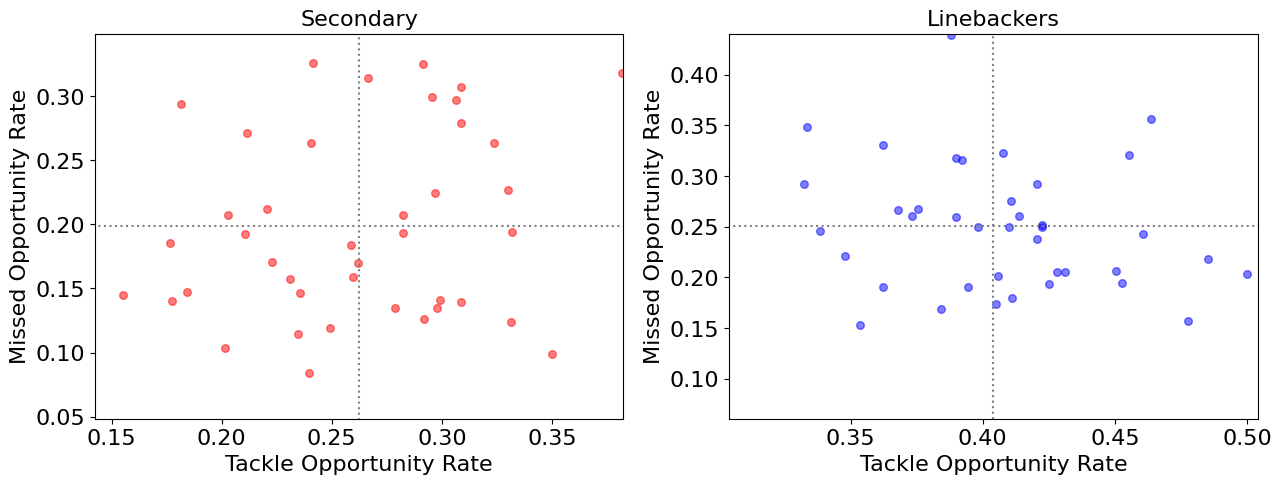

In [9]:
# Create plot of missed opportunity rate vs. tackle opportunity rate for secondary and linebackers

df_s = df_converted_tackles[(df_converted_tackles.position == "FS") | (df_converted_tackles.position == "SS") | (df_converted_tackles.position == "CB")]
df_lb = df_converted_tackles[(df_converted_tackles.position == "ILB") | (df_converted_tackles.position == "OLB")]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

s_mean_tackle_opp = df_s.tackle_opportunity_rate.mean()
s_mean_missed_opp = df_s.missed_opportunity_rate.mean()
window_h = 0.12
window_v = 0.15

lb_max_tackle_opp = df_lb.tackle_opportunity_rate.max()
lb_min_tackle_opp = df_lb.tackle_opportunity_rate.min()
lb_max_missed_opp = df_lb.missed_opportunity_rate.max()
lb_min_missed_opp = df_lb.missed_opportunity_rate.min()

ax[0].scatter(df_s.tackle_opportunity_rate, df_s.missed_opportunity_rate, color="red", s=30, alpha=0.5, label="Secondary")
ax[0].hlines(y=s_mean_missed_opp, xmin=0, xmax=1, linestyles="dotted", color="gray")
ax[0].vlines(x=s_mean_tackle_opp, ymin=0, ymax=1, linestyles="dotted", color="gray")
ax[0].set_xlim([s_mean_tackle_opp - window_h, s_mean_tackle_opp + window_h])
ax[0].set_ylim([s_mean_missed_opp - window_v, s_mean_missed_opp + window_v])
ax[0].set_xlabel("Tackle Opportunity Rate", fontsize=16)
ax[0].set_ylabel("Missed Opportunity Rate", fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=16)
ax[0].set_title("Secondary", fontsize=16)

lb_mean_missed_opp = df_lb.missed_opportunity_rate.mean()
lb_mean_tackle_opp = df_lb.tackle_opportunity_rate.mean()
window_h = 0.1
window_v = 0.19

ax[1].scatter(df_lb.tackle_opportunity_rate, df_lb.missed_opportunity_rate, color="blue", s=30, alpha=0.5, label="Linebackers")
ax[1].hlines(y=lb_mean_missed_opp, xmin=0, xmax=1, linestyles="dotted", color="gray")
ax[1].vlines(x=lb_mean_tackle_opp, ymin=0, ymax=1, linestyles="dotted", color="gray")
ax[1].set_xlim([lb_mean_tackle_opp - window_h, lb_mean_tackle_opp + window_h])
ax[1].set_ylim([lb_mean_missed_opp - window_v, lb_mean_missed_opp + window_v])
ax[1].set_xlabel("Tackle Opportunity Rate", fontsize=16)
ax[1].set_ylabel("Missed Opportunity Rate", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=16)
ax[1].set_title("Linebackers", fontsize=16)
plt.show()

total tackle opportunity rate = 0.33, Safeties = 0.26, LB = 0.40
total tackle conversion rate = 0.47, Safeties = 0.50, LB = 0.45
total missed_opportunities rate = 0.24, Safeties = 0.21, LB = 0.25


Text(0.5, 1.0, 'Missed Opportunity Rate')

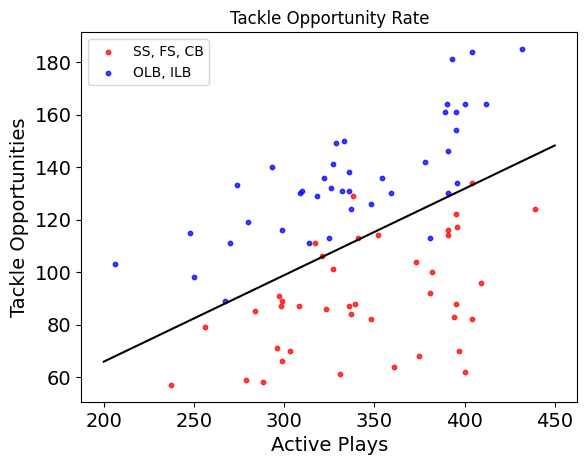

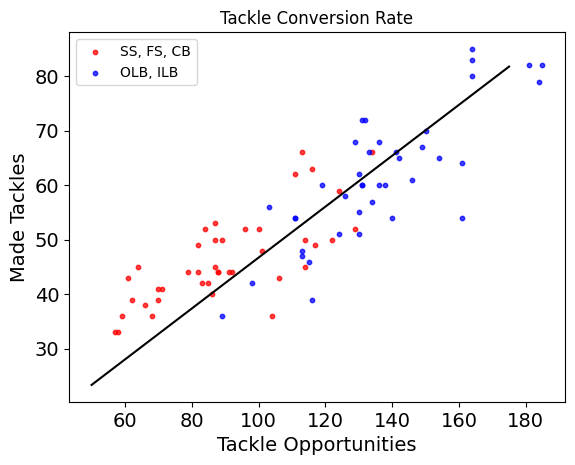

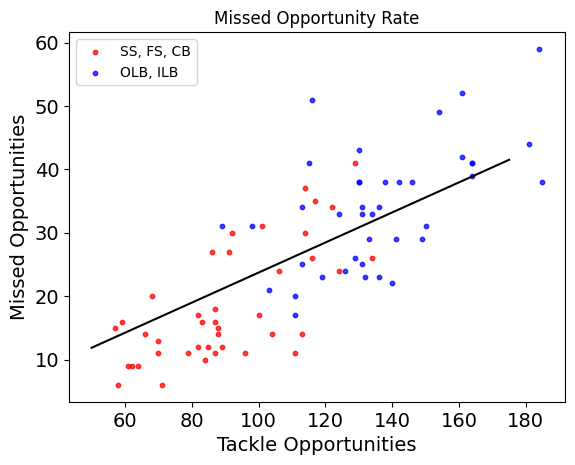

In [10]:
# Plot tackle opportunities vs. active plays, tackle conversion rate vs. tackle opportunities, and missed opportunity rate vs. tackle opportunities for each player

# Segment dataframe by position group
df_converted_tackles_s = df_converted_tackles[(df_converted_tackles.position == "FS") | (df_converted_tackles.position == "SS") | (df_converted_tackles.position == "CB")]
df_converted_tackles_lb = df_converted_tackles[(df_converted_tackles.position == "ILB") | (df_converted_tackles.position == "OLB")]
df_converted_tackles_de = df_converted_tackles[(df_converted_tackles.position == "T") | (df_converted_tackles.position == "DE") | (df_converted_tackles.position == "DT")]

# Tackle Opportunity Rate
x = df_converted_tackles.active_plays.to_numpy()
y = df_converted_tackles.tackle_opportunities.to_numpy()
m_opt = np.dot(x, y)/np.dot(x, x)

x_s = df_converted_tackles_s.active_plays.to_numpy()
y_s = df_converted_tackles_s.tackle_opportunities.to_numpy()
m_opt_s = np.dot(x_s, y_s)/np.dot(x_s, x_s)

x_lb = df_converted_tackles_lb.active_plays.to_numpy()
y_lb = df_converted_tackles_lb.tackle_opportunities.to_numpy()
m_opt_lb = np.dot(x_lb, y_lb)/np.dot(x_lb, x_lb)
print(f"total tackle opportunity rate = {m_opt:.2f}, Safeties = {m_opt_s:.2f}, LB = {m_opt_lb:.2f}")

fig, ax = plt.subplots()
ax.plot(np.linspace(200, 450, 251), m_opt * np.linspace(200, 450, 251), "k-")
ax.scatter(df_converted_tackles_s.active_plays, df_converted_tackles_s.tackle_opportunities, color="red", s=10, alpha=0.75, label="SS, FS, CB")
ax.scatter(df_converted_tackles_lb.active_plays, df_converted_tackles_lb.tackle_opportunities, color="blue", s=10, alpha=0.75, label="OLB, ILB")
# ax.scatter(df_converted_tackles_de.active_plays, df_converted_tackles_de.tackle_opportunities, color="green", s=10, alpha=0.75, label="DE, DT, T")
ax.set_xlabel("Active Plays", fontsize=14)
ax.set_ylabel("Tackle Opportunities", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.legend()
ax.set_title("Tackle Opportunity Rate")

# Tackle Conversion Rate
# Calculating best fit line for tackle conversion rate that runs through the origin
x = df_converted_tackles.tackle_opportunities.to_numpy()
y = df_converted_tackles.made_tackles.to_numpy()
m_opt = np.dot(x, y)/np.dot(x, x)

x_s = df_converted_tackles_s.tackle_opportunities.to_numpy()
y_s = df_converted_tackles_s.made_tackles.to_numpy()
m_opt_s = np.dot(x_s, y_s)/np.dot(x_s, x_s)

x_lb = df_converted_tackles_lb.tackle_opportunities.to_numpy()
y_lb = df_converted_tackles_lb.made_tackles.to_numpy()
m_opt_lb = np.dot(x_lb, y_lb)/np.dot(x_lb, x_lb)
print(f"total tackle conversion rate = {m_opt:.2f}, Safeties = {m_opt_s:.2f}, LB = {m_opt_lb:.2f}")

fig, ax = plt.subplots()
ax.plot(np.linspace(50, 175, 126), m_opt * np.linspace(50, 175, 126), "k-")
ax.scatter(df_converted_tackles_s.tackle_opportunities, df_converted_tackles_s.made_tackles, color="red", s=10, alpha=0.75, label="SS, FS, CB")
ax.scatter(df_converted_tackles_lb.tackle_opportunities, df_converted_tackles_lb.made_tackles, color="blue", s=10, alpha=0.75, label="OLB, ILB")
# ax.scatter(df_converted_tackles_de.tackle_opportunities, df_converted_tackles_de.made_tackles, color="green", s=10, alpha=0.75, label="DE, DT, T")
ax.set_xlabel("Tackle Opportunities", fontsize=14)
ax.set_ylabel("Made Tackles", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.legend()
ax.set_title("Tackle Conversion Rate")

# Missed Opportunity Rate
x = df_converted_tackles.tackle_opportunities.to_numpy()
y = df_converted_tackles.missed_opportunities.to_numpy()
m_opt = np.dot(x, y)/np.dot(x, x)

x_s = df_converted_tackles_s.tackle_opportunities.to_numpy()
y_s = df_converted_tackles_s.missed_opportunities.to_numpy()
m_opt_s = np.dot(x_s, y_s)/np.dot(x_s, x_s)

x_lb = df_converted_tackles_lb.tackle_opportunities.to_numpy()
y_lb = df_converted_tackles_lb.missed_opportunities.to_numpy()
m_opt_lb = np.dot(x_lb, y_lb)/np.dot(x_lb, x_lb)
print(f"total missed_opportunities rate = {m_opt:.2f}, Safeties = {m_opt_s:.2f}, LB = {m_opt_lb:.2f}")


fig, ax = plt.subplots()
ax.plot(np.linspace(50, 175, 126), m_opt * np.linspace(50, 175, 126), "k-")
ax.scatter(df_converted_tackles_s.tackle_opportunities, df_converted_tackles_s.missed_opportunities, color="red", s=10, alpha=0.75, label="SS, FS, CB")
ax.scatter(df_converted_tackles_lb.tackle_opportunities, df_converted_tackles_lb.missed_opportunities, color="blue", s=10, alpha=0.75, label="OLB, ILB")
# ax.scatter(df_converted_tackles_de.tackle_opportunities, df_converted_tackles_de.missed_opportunities, color="green", s=10, alpha=0.75, label="DE, DT, T")
ax.set_xlabel("Tackle Opportunities", fontsize=14)
ax.set_ylabel("Missed Opportunities", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.legend()
ax.set_title("Missed Opportunity Rate")

In [13]:
# Extract statistics on tackle_opportunities and tackle_conversion_rate by position group 
df_converted_tackles_s = df_converted_tackles[(df_converted_tackles.position == "FS") | (df_converted_tackles.position == "SS") | (df_converted_tackles.position == "CB")]
df_converted_tackles_lb = df_converted_tackles[(df_converted_tackles.position == "ILB") | (df_converted_tackles.position == "OLB")]

# extract mean and std of tackle opportunities
print(f"Secondary Tackle Opportunity Rate: mean = {df_converted_tackles_s.tackle_opportunity_rate.mean():.3f} | std = {df_converted_tackles_s.tackle_opportunity_rate.std():.3f}") 
print(f"Linebacker Tackle Opportunity Rate: mean = {df_converted_tackles_lb.tackle_opportunity_rate.mean():.3f} | std = {df_converted_tackles_lb.tackle_opportunity_rate.std():.3f}") 

# extract mean and std of tackle conversion rate
print(f"Secondary Tackle Conversion Rate: mean = {df_converted_tackles_s.tackle_conversion_rate.mean():.3f} | std = {df_converted_tackles_s.tackle_conversion_rate.std():.3f}") 
print(f"Linebacker Tackle Conversion Rate: mean = {df_converted_tackles_lb.tackle_conversion_rate.mean():.3f} | std = {df_converted_tackles_lb.tackle_conversion_rate.std():.3f}") 

Secondary Tackle Opportunity Rate: mean = 0.262 | std = 0.054
Linebacker Tackle Opportunity Rate: mean = 0.404 | std = 0.045
Secondary Tackle Conversion Rate: mean = 0.528 | std = 0.080
Linebacker Tackle Conversion Rate: mean = 0.452 | std = 0.051
